In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

# Summary-like from Tensorflow
from torchsummary import summary

# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

# WFDB
import wfdb

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [13]:
# =============== LOAD ECG DATA ===============

# Load the files
ecg_clean = np.load('all_none_fs1024_e24.npy')
ecg_noisy = np.load('all_none_fs1024_e06.npy')

# Push to CUDA
ecg_clean = torch.from_numpy(ecg_clean).cuda().double()
ecg_noisy = torch.from_numpy(ecg_noisy).cuda().double()

# Reshape for Torch format
ecg_clean = ecg_clean.view( (ecg_clean.shape[0], ecg_clean.shape[2], ecg_clean.shape[1]))
ecg_noisy = ecg_noisy.view( (ecg_noisy.shape[0], ecg_noisy.shape[2], ecg_noisy.shape[1]))

# Normalize ecg_clean per subset
ecg_clean_norm = et.norm_sig(ecg_clean)
ecg_noisy_norm = et.norm_sig(ecg_noisy)

# Create train and validation datasets
train_size = int( (ecg_clean.shape[0])*.80 ) # Get 80%
val_size = int( (ecg_clean.shape[0])*.20 ) # Get 20%

# Use this for checking
total_size = train_size + val_size
if total_size < ecg_noisy.shape[0]:
    train_size = train_size + (ecg_noisy.shape[0] - total_size)

print( f'Total size is: {total_size}' )

Total size is: 5543


In [14]:
# Well instead of having to randomize the data itself, why not the numbers used to index
index_set = np.arange(0, total_size+1)

# split the indexes used for training and validation
train_indexset, val_indexset = random_split( index_set, (train_size, val_size))

# Create DataLoaders for the corresponding train and val sets
traindex_loader = DataLoader( train_indexset, shuffle=True, batch_size=1 )
valdex_loader = DataLoader( val_indexset, shuffle=True, batch_size=1 )

In [15]:
kernel_size = 16
padding_size= int( (kernel_size/2) ) # If odd, add -1

class ae_sampler(nn.Module):
    def __init__(self):
        super(ae_sampler, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 40, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
            nn.BatchNorm1d(40),
            nn.Conv1d(40, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
            nn.BatchNorm1d(20),
            nn.Conv1d(20, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
            nn.BatchNorm1d(20),
            nn.Conv1d(20, 40, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
            nn.BatchNorm1d(40),
            nn.Conv1d(40, 1, kernel_size, stride=1, padding=8 ), nn.ELU(True), # 521
            nn.BatchNorm1d(1),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 40, kernel_size, stride=1, padding=8 ), nn.ELU(True), # 521
            nn.BatchNorm1d(40),
            nn.ConvTranspose1d(40, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
            nn.BatchNorm1d(20),
            nn.ConvTranspose1d(20, 20, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
            nn.BatchNorm1d(20),
            nn.ConvTranspose1d(20, 40, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
            nn.BatchNorm1d(40),
            nn.ConvTranspose1d(40, 1, kernel_size, stride=2, padding=7 ), nn.ELU(True), # 521
            nn.BatchNorm1d(1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

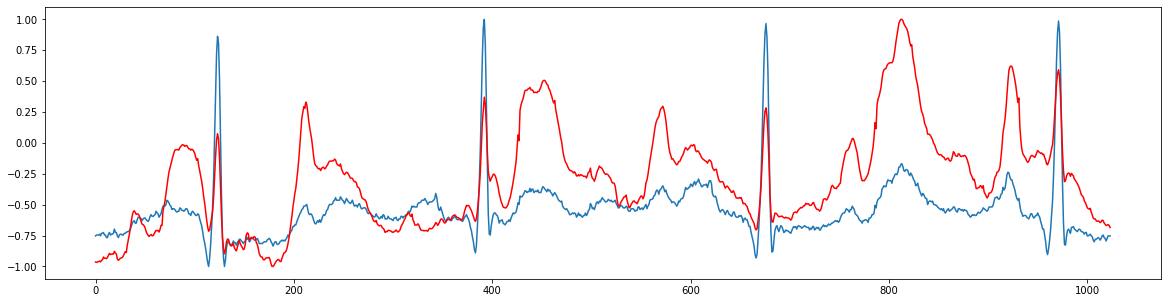

In [16]:
ecg_noisy_tensor = e06
ecg_clean_tensor = e24
# Preview ECG data
index = 8
plt.figure( figsize=(20,5) )
plt.plot( ecg_clean_tensor[index][0].cpu() )
plt.plot( ecg_noisy_tensor[index][0].cpu(), c='red' )

In [17]:
# ============================================
# Run this part to test if your data is properly shaped with the model
# ============================================
model = ae_sampler().cuda()
model.double() # Since data is using double, force model to use double rather than floatType

# Data below is double dtype
temp_data = ecg_noisy_tensor[3]
print( f'Original shape: {temp_data.shape}')

# Change the shape/view of the data (this will be the shape to be used when iterating from the loader) (1, 1, 1024)
temp_data = temp_data.view( 1, ecg_clean_tensor.shape[1], ecg_clean_tensor.shape[2])
print( f'Modified shape: {temp_data.shape}')

# Check if model will accept the data's new shape
encoder = model.encoder( temp_data )
decoder = model.decoder( encoder )

print("\n")
print( f'Encoder Shape: {encoder.shape}' )
print( f'Decoder Shape: {decoder.shape}' )

temp_preview = ecg_noisy_tensor[3].cpu()
temp_preview = temp_preview.view( temp_preview.shape[1], temp_preview.shape[0])
print( f'Required shape is: {temp_preview.shape}')

Original shape: torch.Size([1, 1024])
Modified shape: torch.Size([1, 1, 1024])


Encoder Shape: torch.Size([1, 1, 65])
Decoder Shape: torch.Size([1, 1, 1024])
Required shape is: torch.Size([1024, 1])


In [18]:
def train_model(model, trainloader, epochs):
    elapsed_start = time.time()
    train_loss = []
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    
    for epoch in range(epochs):
        # Running loss computed at the end
        running_loss = 0.0        
        # start timer
        epoch_start = time.time()
        # Loop through the entire dataset
        for i, data_index in enumerate(traindex_loader):
            # Load the noise sample
            index = data_index.numpy()[0]
            noise_samp = ecg_noisy_tensor[index]
            clean_samp = ecg_clean_tensor[index]
            noise_samp = noise_samp.view( 1, noise_samp.shape[0], noise_samp.shape[1])
            clean_samp = clean_samp.view( 1, clean_samp.shape[0], clean_samp.shape[1])
            # Convert x_samps to tensors and in cuda
            optimizer.zero_grad()
            # one_sig = noise_sig
            # one_sig = noise_sig.view( noise_sig.shape[1], noise_sig.shape[0], 1)
            
            x_prime = model( noise_samp )
            
            loss = criterion( x_prime, clean_samp) # or loss function
            
            # Backpropagation
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
        
            loss = running_loss / len(trainloader)
        
            train_loss.append(loss)

        # ===== Epoch timer =====
        epoch_end = time.time()
        time_total = epoch_end - epoch_start
        print( f"Epoch {epoch+1} of {epochs} || time: {time_total:.2f} || loss = {loss}")
        # ===== Total training elapsed time =====
    elapsed_end = time.time()
    elapsed_total = elapsed_end-elapsed_start
    elapsed_mins = int(elapsed_total/60)
    elapsed_secs = int(elapsed_total - (60 * elapsed_mins))
    print(f'Elapsed time: {elapsed_total:.2f}, (in mins: {elapsed_mins}:{elapsed_secs})')

    return train_loss

In [19]:
model = ae_sampler().cuda()
model.double()
losses = train_model( model, traindex_loader, 10)
# train_model( ae_sampler, noiseloader, 1)

Epoch 1 of 10 || time: 51.35 || loss = 0.16247984433556106
Epoch 2 of 10 || time: 53.74 || loss = 0.09837749906920511
Epoch 3 of 10 || time: 51.20 || loss = 0.09566935784302222
Epoch 4 of 10 || time: 50.90 || loss = 0.09436307747420328
Epoch 5 of 10 || time: 50.82 || loss = 0.09337518083892789
Epoch 6 of 10 || time: 51.14 || loss = 0.09263435168955997
Epoch 7 of 10 || time: 56.09 || loss = 0.09190553454828805
Epoch 8 of 10 || time: 54.12 || loss = 0.09151322031644728
Epoch 9 of 10 || time: 54.35 || loss = 0.09110708548706263
Epoch 10 of 10 || time: 53.95 || loss = 0.0907163112970161
Elapsed time: 527.66, (in mins: 8:47)


In [28]:
ecg_noisy_test = ecg_noisy_tensor[0:126]

In [29]:
result = model.encoder( ecg_noisy_test )
result = model.decoder( result ) 
result = result.detach().cpu().numpy()

In [30]:
print( result.shape )

(126, 1, 1024)


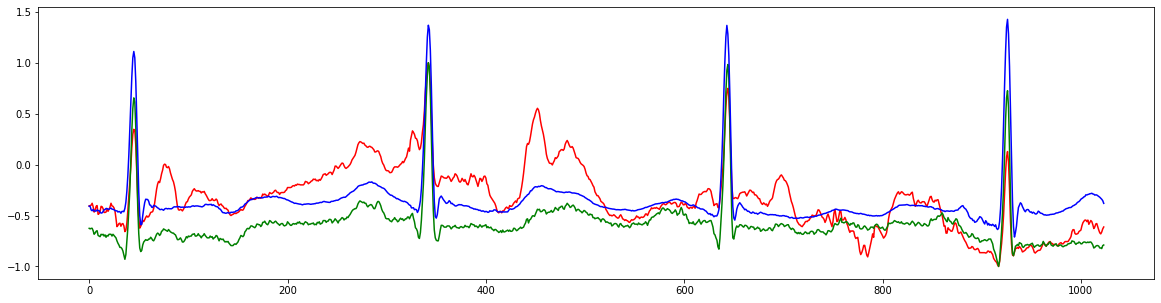

In [38]:
index = 0
plt.figure( figsize=(20,5) )
plt.plot( ecg_noisy_test[index][0].cpu(), c='red', label='original data' )
plt.plot( ecg_clean_tensor[index][0].cpu(), c='green', label='original data' )
plt.plot( result[index][0], c='blue', label='decoder result' )